<a href="https://colab.research.google.com/github/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/FL/DataKindHousingChallenge3GeoMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has Folium interactive maps of Florida for visualizing data from Challenge 3 of DataKinds's Fall 2024 Housing Challenge DataKit.

There's a lot more background in my [Challenge 3 notebook](https://github.com/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/DataKindChallenge3.ipynb)

I'm having trouble saving this in GitHub for some reason, so have cleared all of the outputs.  
**You will have to execute the cells to regenerate the Folium map**


*Future work*

* add filters to Folium map

* try using MapBox for interactive tool

* and plotly for interactive graphs (have examples in "messy" notebook)

* and have selecting things from plotly graphs filter what is show in geo map and vice versa

* and make it easier to visualize overlaps of things. The layers get very cluttered if have more than one active!

* and get rid of the "holes" by being smarter about data cleanup (don't drop rows so aggressively)


## Setup

*Import libraries, read in datasets*

I think I drop rows too aggressively in here for bad data, resulting in "holes" in the geo visualizations later


We import:

*   Python Pandas for data manipulation
*   Seaborn (built on top of Matplotlib) for most of our visualizations
*   matplotlib_venn for making Venn diagrams
*   zipfile, requests, io for fetching and reading the datasets


In [5]:
# import libraries

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles, layout
import seaborn as sns
import zipfile
import requests, io

import numpy as np
import geopandas as gpd
import folium
# from mpl_toolkits.axes_grid1 import make_axes_locatable

Next we read in the [1.1 version of DataKind's Fall 2024 housing dataset](https://github.com/datakind/datakit-housing-fall-2024/releases/tag/v1.1), which was provided by DataKind for use in the DataKit event.

Version 1.1 has different column names than the 1.0 version, and so is not consistent with the [EODatascape data dictionary](https://www.google.com/url?q=https%3A%2F%2Feodatascape.datakind.org%2Fdata-dictionary). It is generally obvious from the column names which ones they correspond to. (Version 1.0 had incomplete data -- less than 2000 of Florida's >5000 census tracts)

We rename some of the columns to be consistent with v1.0 naming conventions, but not all of them.

We also do a bit of data cleanup, dropping a small number of census tracts with bogus values, and adding some new columns that will be convenient for making visualizations.


In [6]:
# Read DataKind EODataScape housing dataset into Panda dataframe df

version=1.1
url = f"https://github.com/datakind/datakit-housing-fall-2024/releases/download/v{version}/housing-data.zip"
filename = "housing-data/FL/data_1-FL.csv"

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)

# rename some columns because the original dataset used different names than the current one and I don't want to change everything
# don't do renaming if using the v1.0 dataset
if(version==1.1):
  column_renames={
      "hud_opportunity_zones" : "opzone",
      "cdfi_fund_invest_areas" : "investment_areas",
      "lihtc_qualified_tracts" : "qct",
      "cdfi_fund_economic_distress" : "economic_distress_pop_agg",
      "county" : "county_name",
      "county_fips_code" : "county",
  }
  df=df.rename(columns=column_renames)

# add a boolean column for whether a census tract has non-negligible CDFI lending
df["has_cdfi_lending"]=df.total_cdfi_lending.apply(lambda x: x>10000)

# make "cdfi_fund_invest_areas" a clone of "investment_areas"
df["cdfi_fund_invest_areas"]=df.investment_areas

# change "investment_areas" from YES/NO to 1/0,
df["investment_areas"]=df.investment_areas.apply(lambda x: 1 if x=="YES" else 0)

#  add a column indicating which set of government programs a Census tract belongs to (CDFI Investment Areas, HUD Qualified Census Tract, HUD Opportunity Zone)
#  values are like "101", "010" etc indicating membership in investment_areas, opzone, and qct by digit
df["venn_key"]=df.apply(lambda x: str(x.investment_areas)[0]+str(x.opzone)[0]+str(x.qct)[0],axis=1)

# make a human friendly versions of that column, combining the rare values, to be used for pie charts and histograms
df["overlap_label"]=df.venn_key.map({
    "000":"none",
    "100":"ia",
    "101":"ia+qct",
    "111":"all",
    "110":"ia+op",
    "011":"other",
    "010":"other",
    "001":"other"
})

df["overlap_label2"]=df.venn_key.map({
    "000":"none",
    "100":"ia only",
    "101":"hud",
    "111":"hud",
    "110":"hud",
    "011":"hud",
    "010":"hud",
    "001":"hud"
})

# add a similar column combinining investment_areas, has_cdfi_lending, and economic_distress
df["venn_ia_hl_ed"]=df.apply(lambda x: str(x.investment_areas)[0]+str("1" if x.has_cdfi_lending else "0")[0]+str("1" if x.economic_distress_pop_agg=="YES" else "0")[0],axis=1)

# drop rows for which total_cdfi_lending or num_mortgages_origin is not defined
display(f"dropping rows with missing total_cdfi_lending: {df.total_cdfi_lending.isna().sum()}")
display(f"dropping rows with missing num_mortgages_origin: {df.num_mortgages_origin.isna().sum()}")
df.dropna(subset=["num_mortgages_origin","total_cdfi_lending"],inplace=True)

# set percentile columns for cdfi lending and num mortages originated
df["pctile_cdfi_lending_fl"]=df.total_cdfi_lending.rank(pct=True)*100
df["pctile_mortgages_origin_fl"]=df.num_mortgages_origin.rank(pct=True)*100

df.head().T

'dropping rows with missing total_cdfi_lending: 124'

'dropping rows with missing num_mortgages_origin: 83'

,0,1,2,3,4
geoid,12001000600,12001000809,12001001100,12001001202,12001001519
geoid_year,2020,2020,2020,2020,2020
state,Florida,Florida,Florida,Florida,Florida
county_name,Alachua County,Alachua County,Alachua County,Alachua County,Alachua County
state_fips_code,12,12,12,12,12
...,...,...,...,...,...
overlap_label,all,ia+qct,none,none,ia+qct
overlap_label2,hud,hud,none,none,hud
venn_ia_hl_ed,111,101,010,010,111
pctile_cdfi_lending_fl,17.38176,0.967871,20.933945,99.620834,12.133307


Next we read in a dataset downloaded from census.gov and stored in Github which contains the population and number of households per census tract, and merge it with the DataKind dataset.

TODO: add more info about data source was it CensusReporter? data.census.gov?

This results in a few more census tracts being dropped, but not many.

In [7]:
# read in the dataset downloaded from census.gov, which has population and number of households per census tract

url="https://raw.githubusercontent.com/datakind/datakit-housing-fall-2024/refs/heads/main/challenge-3/FL/DECENNIALDP2020.DP1_2024-10-12T222820/DECENNIALDP2020.DP1-Data.csv"

population_df_columns={
    "GEO_ID":"full_geoid",
    "NAME":"full_name",
    "DP1_0001C":"total_population",
    "DP1_0132C":"total_households"
}

# the first two rows of the dataset are column descriptions and Florida-wide totals. Ignore them, as well as unneeded columns in dataframe
# need to set low_memory=False to avoid a warning because columns have mixed datatypes because of the first two rows being special
dfpop = pd.read_csv(url,low_memory=False).loc[2:,[*population_df_columns]].rename(columns=population_df_columns)

# make population and households columns numeric, now we've dropped the descriptions row
dfpop.total_population=dfpop.total_population.astype(int)
dfpop.total_households=dfpop.total_households.astype(int)

# the dataset uses fully qualified geoids that encode country, with format:
# 1400000US12001000201
# we just want the last 11 digits for consistency with other dataset
dfpop["geoid"]=dfpop["full_geoid"].apply(lambda x: x.split("US")[1]).astype(int)

display("census population dataset: ",dfpop.head())

# merge into main dataframe
display("merging population totals data into main dataframe")
display("dfpop shape:",dfpop.shape, "df shape: ",df.shape)
df=df.merge(dfpop,on="geoid",how="left")
display("merged df shape: ", df.shape)

'census population dataset: '

,full_geoid,full_name,total_population,total_households,geoid
2,1400000US12001000201,Census Tract 2.01; Alachua County; Florida,4348,1711,12001000201
3,1400000US12001000202,Census Tract 2.02; Alachua County; Florida,4782,1695,12001000202
4,1400000US12001000301,Census Tract 3.01; Alachua County; Florida,3384,1808,12001000301
5,1400000US12001000302,Census Tract 3.02; Alachua County; Florida,2644,1257,12001000302
6,1400000US12001000400,Census Tract 4; Alachua County; Florida,5330,2117,12001000400


'merging population totals data into main dataframe'

'dfpop shape:'

(5160, 5)

'df shape: '

(5011, 392)

'merged df shape: '

(5011, 396)

In [8]:

display("dropping rows with unknown demographics")
display(df.shape)
df.drop(df[df.pov_white_nh_pct_est<0].index,inplace=True)
df.drop(df[df.pov_pct_est<0].index,inplace=True)
df.drop(df[df.pop_pct_white<0].index,inplace=True)

display(df.shape)

display("adding columns for non-white and poor populations")

df["pop_pct_nonwhite"]=100-df.pop_pct_white
df["pov_nonwhite_pct_est"]=df.apply(
    lambda x: 0 if x.pov_white_nh_pct_est>=x.pov_pct_est else (x.pov_pct_est-x.pov_white_nh_pct_est),
    axis=1)
df["non_white_population"]=((100-df.pop_pct_white)*df.total_population//100)
df["poor_population"]=(df.pov_pct_est*df.total_population//100)
df["poor_non_white_population"]=df.apply(
    lambda x: 0 if x.pov_white_nh_pct_est>=x.pov_pct_est else (x.pov_pct_est-x.pov_white_nh_pct_est)*x.total_population/100,
    axis=1)


'dropping rows with unknown demographics'

(5011, 396)

(4988, 396)

'adding columns for non-white and poor populations'

In [9]:
df.rename(columns={
    'flood_risk_30yr_pctile': 'flood_risk_30yr_share_pctile',
    'fire_risk_30yr_pctile': 'fire_risk_30yr_share_pctile'
    },inplace=True)
# drop impossible values
display("dropping rows with impossible fire or flood shares")
display(df.shape)
df.drop(df[df.flood_risk_30yr_share>100].index,inplace=True)
df.drop(df[df.fire_risk_30yr_share>100].index,inplace=True)
display(df.shape)

#df["flood_risk_30yr_share"]=df["flood_risk_30yr_share"].map(lambda x: 100 if x>100 else x)
#df["fire_risk_30yr_share"]=df["fire_risk_30yr_share"].map(lambda x: 100 if x>100 else x)

# make buckets
df["mortgages_pctile_bucket"]=df.pctile_mortgages_origin_fl.apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))
df["cdfi_lending_pctile_bucket"]=df.pctile_cdfi_lending_fl.apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))
for col in ["traffic_prox_pctile", "haz_waste_prox_pctile","air_toxics_cancer_pctile","flood_risk_30yr_share_pctile","fire_risk_30yr_share_pctile"]:
    df[f"{col}_bucket"]=df[col].apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))

'dropping rows with impossible fire or flood shares'

(4988, 401)

(4938, 401)

## Geo

In [10]:
# read in geo data

# perhaps I should be using 2020 or 2022 data instead? Not sure
url="https://github.com/kodiakpony/datakit-housing-fall-2024/raw/refs/heads/main/challenge-3/FL/cb_2023_12_tract_500k.zip"
gdf = gpd.read_file(url)
gdf["geoid"]=gdf["GEOID"].astype(int)
gdf.set_index("geoid", inplace=True)

columns=[
    'geoid',
    'full_name',
    'opzone',
    'investment_areas',
    'qct',
    'overlap_label',
    'economic_distress_pop_agg',
    'has_cdfi_lending',
    'flood_risk_30yr_share',
    'flood_risk_30yr_share_pctile',
    'fire_risk_30yr_share_pctile',
    'fire_risk_30yr_share',
    'traffic_prox',
    'haz_waste_prox',
    'air_toxics_cancer',
    'total_cdfi_lending',
    'pctile_cdfi_lending_fl',
    'pctile_mortgages_origin_fl',
    'num_mortgages_origin',
    'total_population',
    'total_households',
    'pov_pct_est',
    'pov_white_nh_pct_est',
    'pop_pct_white',
    'pop_pct_nonwhite',
    'pov_nonwhite_pct_est',
    'non_white_population',
    'poor_population',
    'poor_non_white_population',
    'mortgages_pctile_bucket',
    'cdfi_lending_pctile_bucket',
]
merged_gdf = gdf.merge(df.loc[:,columns], on='geoid')


In [ ]:
df.pctile_cdfi_lending_fl

,pctile_cdfi_lending_fl
0,17.381760
1,0.967871
2,20.933945
3,99.620834
4,12.133307
...,...
5006,53.192975
5007,53.192975
5008,99.321493
5009,99.940132


<Axes: >

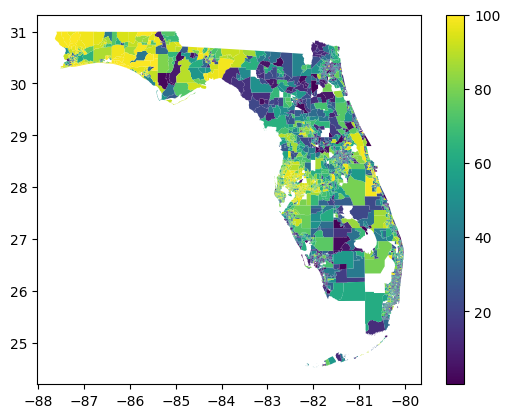

In [ ]:
merged_gdf.plot(column="pctile_cdfi_lending_fl",legend=True)

<Axes: >

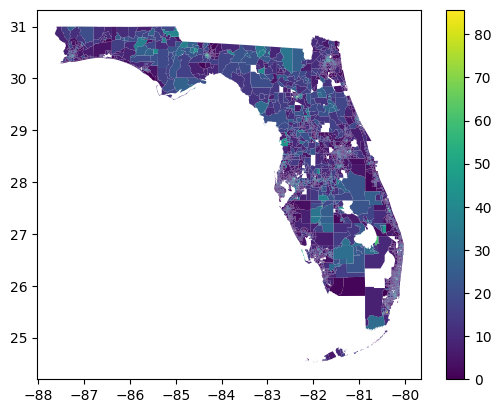

In [ ]:
merged_gdf.plot(column="pov_pct_est",legend=True)

<Axes: >

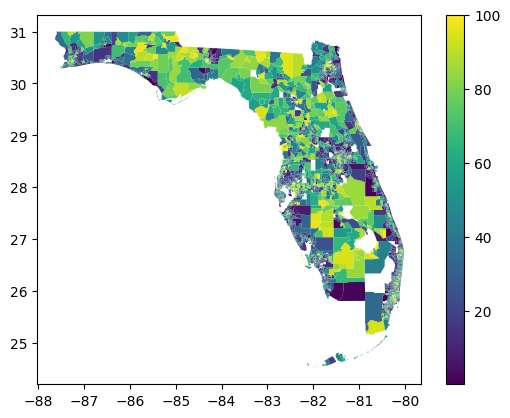

In [11]:
merged_gdf["pov_pct_pctile"]=merged_gdf.pov_pct_est.rank(pct=True)*100
merged_gdf.plot(column="pov_pct_pctile",legend=True)

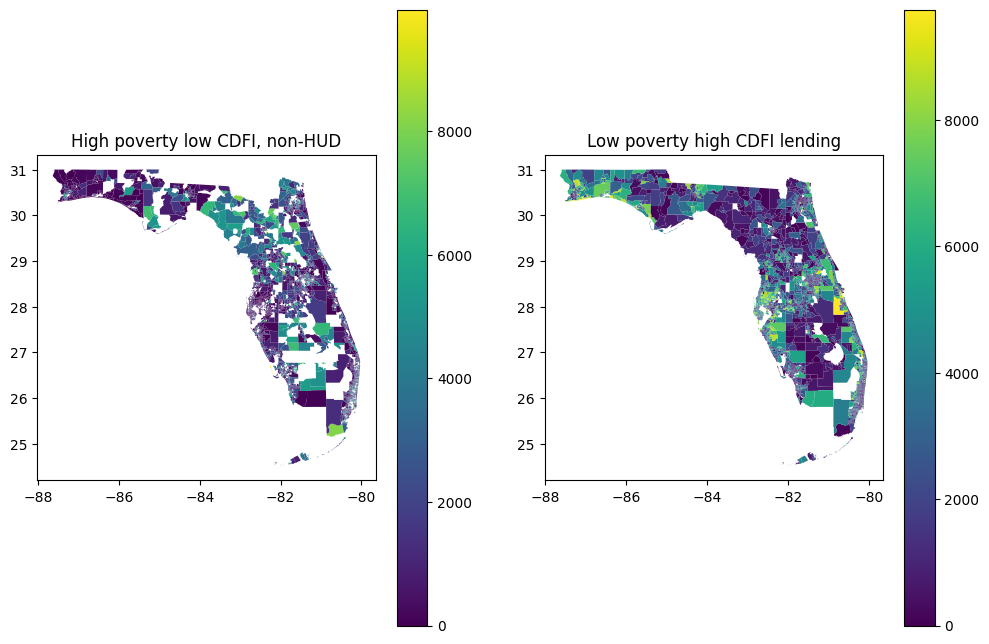

In [35]:
merged_gdf["under_invest_index"]=merged_gdf.apply(lambda x: x.pov_pct_pctile*(100-x.pctile_cdfi_lending_fl),axis=1)
merged_gdf["over_invest_index"]=merged_gdf.apply(lambda x: (100-x.pov_pct_pctile)*x.pctile_cdfi_lending_fl,axis=1)
#display(merged_gdf.query("opzone==0 and qct==0").plot(column="under_invest_index",legend=True))
#display(merged_gdf.plot(column="over_invest_index",legend=True))
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
merged_gdf.query("opzone==0 and qct==0").plot(column="under_invest_index",legend=True,ax=ax[0])
ax[0].set_title("High poverty low CDFI, non-HUD")
merged_gdf.plot(column="over_invest_index",legend=True,ax=ax[1])
ax[1].set_title("Low poverty high CDFI lending")
plt.show()

In [19]:
merged_gdf.loc[:,["under_invest_index","pov_pct_pctile","pctile_cdfi_lending_fl"]].sort_values("under_invest_index")

,under_invest_index,pov_pct_pctile,pctile_cdfi_lending_fl
1090,0.000000,86.330498,100.000000
1254,0.496276,24.868368,99.980044
3052,0.874746,3.371810,99.740571
750,1.130361,28.321183,99.960088
103,1.451242,1.913730,99.241668
...,...,...,...
3539,9840.202506,99.534224,1.137498
1590,9855.003177,98.855812,0.309319
1832,9898.408394,99.291211,0.309319
4354,9920.175614,100.000000,0.798244


In [22]:
merged_gdf.loc[:,["over_invest_index","pov_pct_pctile","pctile_cdfi_lending_fl"]].sort_values("over_invest_index")

,over_invest_index,pov_pct_pctile,pctile_cdfi_lending_fl
4354,0.000000,100.000000,0.798244
1221,0.012528,99.959498,0.309319
3114,0.062034,99.979749,3.063261
1045,0.208533,99.878493,1.716224
1832,0.219242,99.291211,0.309319
...,...,...,...
3052,9637.750776,3.371810,99.740571
1298,9668.608567,1.022681,97.685093
910,9695.762276,1.549210,98.483337
103,9734.245050,1.913730,99.241668


## Folium


In [ ]:
##@title This creates a Folium Chloropleth map with layers and popups
import folium

popup = folium.GeoJsonPopup(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
#    fields=["county", "opzone", "qct", "investment_areas"],
#    aliases=["County:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)

tooltip = folium.GeoJsonTooltip(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
#    fields=["county", "opzone", "qct", "investment_areas"],
#    aliases=["County:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

def make_chloropleth(column,fill_color,name,legend_name,show):
  cp=folium.Choropleth(
      geo_data=merged_gdf,
      name=name,
      data=merged_gdf,
      columns=['geoid',column],
      key_on='feature.properties.geoid',
      fill_color=fill_color, #'YlGnBu',
      fill_opacity=0.5,
      line_opacity=0.2,
      highlight=True,
      legend_name=legend_name,
      popup_keep_highlighted=True,
      zoom_on_click=True,
      show=show,
  )
#  tooltip.add_to(cp.geojson)
#  popup.add_to(cp.geojson)
  return cp

# Create a base map
ctr=merged_gdf.geometry.centroid
center_latitude=(ctr.y.max()+ctr.y.min())/2
center_longitude=(ctr.x.max()+ctr.x.min())/2
#center_longitude=(merged_gdf.geometry.centroid.x.mean()
m = folium.Map(location=[center_latitude, center_longitude],
               zoom_start=7,
               min_zoom=7,
               tiles="cartodb positron"
               )
#m=folium.Map()


# Create the Investment Areas choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.investment_areas==1],
    name='Investment Areas',
    fill_color='#aaaaff',
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Investment Areas',
    show=False
).add_to(m)

# Create the HUD Qualfied Census Tract choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.qct==1],
    name='HUD Qualified Census Tracts',
#    data=merged_gdf[merged_gdf.qct==1],
 #   columns=['unique_id_column', 'value_column'],
#    columns=['geoid','qct'],
#    key_on='feature.properties.geoid',
#    fill_color='YlGnBu',
    fill_color="red",
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Qualified Census Tracts',
    show=False
).add_to(m)


# Create the HUD opportunity zones choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.opzone==1],
    name='HUD Opportunity Zones',
    fill_color='yellow',
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Opzone',
    show=False
).add_to(m)

make_chloropleth("pctile_cdfi_lending_fl","YlOrRd","cdfi_lending_pctile","cfdi_lending_pctile",True).add_to(m)
make_chloropleth("pov_pct_est","YlOrRd","percent_poverty","percent_poverty",False).add_to(m)
make_chloropleth("pop_pct_nonwhite","YlGnBu","flood_risk","flood_risk",False).add_to(m)
make_chloropleth("fire_risk_30yr_share","YlOrRd","fire_risk","fire_risk",False).add_to(m)
make_chloropleth("flood_risk_30yr_share","YlGnBu","flood_risk","flood_risk",False).add_to(m)

cp2=folium.Choropleth(
    geo_data=merged_gdf,
    name="tooltips and popups",
#    fill_color="YlOrRd", #'YlGnBu',
    fill_color='#aaaaff',
    fill_opacity=0.1,
    line_opacity=0.1,
    highlight=True,
    legend_name="tooltips",
    popup_keep_highlighted=True,
    zoom_on_click=True,
    show=True,
)
tooltip.add_to(cp2.geojson)
popup.add_to(cp2.geojson)
cp2.add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Pan and Zoom map starting position to include overlays
folium.FitOverlays().add_to(m)

# Display the map
m


In [ ]:
import folium


# @title This cell creates a Folium map with markers colored by gov program and filtered by query string, with tooltips and popups { run: "auto" }

#filter_string = "county==31 and investment_areas==1" # @param ["county_name=='Marion County'", "investment_areas==0 and (opzone==1 or qct==1)", "county_fips_code==31 and investment_areas==1"] {allow-input: true}
filter_string="NAMELSADCO=='Marion County'"
#filter_string="investment_areas==0 and (opzone==1 or qct==1)" #county==31" # and investment_areas==1"
# let's try using GeoJSON instead of chloropleth
#filter_string = "opzone==1 and qct==1 and county==31"

#merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf = gdf.merge(data, on='unique_id_column')

# Create a base map
#ctr=merged_gdf.geometry.centroid
#center_latitude=(ctr.y.max()+ctr.y.min())/2
#center_longitude=(ctr.x.max()+ctr.x.min())/2
#center_longitude=(merged_gdf.geometry.centroid.x.mean()
m = folium.Map(#location=[center_latitude, center_longitude],
#               zoom_start=7,
               min_zoom=6,
               tiles="cartodb positron"
               )

popup = folium.GeoJsonPopup(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
#    fields=["county", "opzone", "qct", "investment_areas"],
#    aliases=["County:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)


tooltip = folium.GeoJsonTooltip(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
#    fields=["county", "opzone", "qct", "investment_areas"],
#    aliases=["County:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

# style_function parameters: https://leafletjs.com/reference.html#path-option


#You can use: ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen',
# 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] i
# con_color (str, default 'white') – The color of the drawing on the marker.

merged_gdf2["geometry"] = merged_gdf2.centroid
merged_gdf2=merged_gdf.query(filter_string)

#merged_gdf2["geometry"] = merged_gdf2.centroid
#merged_gdf2=merged_gdf2.set_geometry("centroid")
folium.GeoJson(
    merged_gdf2,
    zoom_start=7,
    min_zoom=7,

#    marker=folium.CircleMarker(radius=4, fill_color="orange", fill_opacity=0.4, color="orange", weight=1),
    marker=folium.Marker(icon=folium.Icon(icon='star')),
#    marker=folium.Marker(),
    style_function=lambda feature: {
      "fillColor": "green"
      if feature["properties"]["opzone"]==1
      else "#ffff00",
      "color": "green"
      if feature["properties"]["opzone"]==1
      else "#ffff00",
      "markerIcon": "info-sign",
      "markerIconColor": "green",
      "markerColor": "lightgray"
      if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==0
      else (
        "beige" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==1
        else (
            "purple" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==1
            else (
                "blue" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==1
                else (
                    "green" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==1
                    else (
                        "darkpurple" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==0
                        else (
                            "darkblue" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==0
                            else (
                                "darkgreen" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==0
                                else "red"
                            )
                        )
                    )
                )
            )
        )
      ),

#      else "blue",
#      if feature["properties"]["investment_areas"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["opzone"]==0

 #     "show": True
 #     if feature["properties"]["opzone"]==1
 #     else False,
#      "show": False,
      "weight": 1,
      "radius": 4,
#      "markerOpacity": 0.2,
#      "fillOpacity": 0.2,
#      "dashArray": "5, 5",
    },
#    style_function=lambda x: {
#        "fillColor": colors[x['properties']['service_level']],
#        "radius": (x['properties']['lines_served'])*30,
#    },
    popup_keep_highlighted=True,
    highlight_function=lambda x: {"fillOpacity": 0.8},
#    highlight=True,  # highlight doesn't seem to exist, but highlight_function and popup_keep_highlighted do
    tooltip=tooltip,
    popup=popup,
    zoom_on_click=True,
    #      if "e" in feature["properties"]["NAMELSADCO"].lower()
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Pan and Zoom map starting position to include overlays
folium.FitOverlays().add_to(m)

# Display the map
m

